In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns

# To import scripts from different directory
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, "/".join([parent_dir, "src"])) 

from scipy.stats import rankdata
from rate_bnn import *
from utils import *
from BayesNN import BNN

/home/jonathan/miniconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .linbin import fast_linbin
/home/jonathan/miniconda2/lib/python2.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:11: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._smoothers_lowess import lowess as _lowess


# Build and train network, compute RATE

In [2]:
#
# Get data for binary classification, train BNN and then compute RATE
#

# Settings
crop_size = 5

# Training settings
n_epochs = 10
batch_size = 256

# Test settings - the number of posterior samples
n_test_samples = 100

x_train, y_train, x_test, y_test = load_mnist(False, True, crop_size, [0,1]) # Load data

p = x_train.shape[1]
C = y_train.shape[1]
image_size = int(p**0.5)

# Network architecture
layers = []
layers.append(tf.keras.layers.Reshape([image_size, image_size, 1], input_shape=(p,)))
layers.append(tf.keras.layers.Conv2D(32, (5, 5), activation='relu'))
layers.append(tf.layers.Flatten())
layers.append(tf.keras.layers.Dense(512, activation='relu'))
layers.append(tfp.layers.DenseLocalReparameterization(C))

tf.reset_default_graph()
    
bnn = BNN(layers, p, C, False) # Create and train network
losses = bnn.train(x_train, y_train, n_epochs, batch_size)
    
test_logits = bnn.sample_logits(x_test, n_test_samples) # Sample logits
test_acc = sampled_accuracies(test_logits, y_test)
print "Test accuracy = {} \pm {}".format(test_acc.mean(), test_acc.std())
    
# Compute RATE
M_W, V_W, b = bnn.var_params() # Means and covariances of the variational parameters (final layer weight matrix elements)
X = x_test
H = bnn.compute_H(X) # (Deterministic) activations of penultimate network layer
rate = RATE_BNN(X, H, M_W, V_W, b, C, effect_size_analogue="covariance")

x_train has shape (12665, 324)
y_train has shape (12665, 1)
x_test has shape (2115, 324)
y_test has shape (2115, 1)
Test accuracy = 0.999380614657 \pm 0.00022866765559
Computing RATE with 324 variables
Variable #:
0 100 200 300 done


# Compute test accuracy while shuffling pixels

In [18]:
# Remove pixels by their rate values and compute test accuracy
def rank_array(arr):
    assert arr.ndim==1
    return (arr.shape[0] - rankdata(arr)).astype(int)

def reverse_ranks(rankarr):
    return rankarr.shape[0] - rankarr - 1

rate_ranks = rank_array(rate)

n_test_samples = 20
n_shuffle_repeats = 10
n_selection_repeats = 20
n_shuffled_pixels = np.arange(0, p+1, 4)

mean_test_accuracy = lambda x: sampled_accuracies(bnn.sample_logits(x, n_test_samples), y_test).mean()

res = {"RATE_high" : [], "RATE_low" : [], "random" : []}

for n_pix in n_shuffled_pixels:
    
    print "Shuffling {} pixels...".format(n_pix)
    
    accuracies = {k :[] for k in res.keys()}

    for _ in range(n_shuffle_repeats):
        
        # High RATE pixels
        x_test_tmp = np.copy(x_test)
        for pix_idx in np.where(rate_ranks<n_pix)[0]:
            np.random.shuffle(x_test_tmp[:,pix_idx])
        
        # This mean over MC samples
        accuracies["RATE_high"].append(mean_test_accuracy(x_test_tmp))
        
        # Low RATE pixes
        x_test_tmp = np.copy(x_test)
        for pix_idx in np.where(reverse_ranks(rate_ranks)<n_pix)[0]:
            np.random.shuffle(x_test_tmp[:,pix_idx])
            
        # This mean over MC samples
        accuracies["RATE_low"].append(mean_test_accuracy(x_test_tmp))
        
    # Randomly selected pixels
    for _ in range(n_selection_repeats):
        for _ in range(n_shuffle_repeats):
            x_test_tmp = np.copy(x_test)
            for pix_idx in np.random.choice(p, size=n_pix, replace=False):
                np.random.shuffle(x_test_tmp[:,pix_idx])
            accuracies["random"].append(mean_test_accuracy(x_test_tmp))
    
    for k, v in accuracies.iteritems():
        res[k].append(v)

Shuffling 0 pixels...
Shuffling 4 pixels...
Shuffling 8 pixels...
Shuffling 12 pixels...
Shuffling 16 pixels...
Shuffling 20 pixels...
Shuffling 24 pixels...
Shuffling 28 pixels...
Shuffling 32 pixels...
Shuffling 36 pixels...
Shuffling 40 pixels...
Shuffling 44 pixels...
Shuffling 48 pixels...
Shuffling 52 pixels...
Shuffling 56 pixels...
Shuffling 60 pixels...
Shuffling 64 pixels...
Shuffling 68 pixels...
Shuffling 72 pixels...
Shuffling 76 pixels...
Shuffling 80 pixels...
Shuffling 84 pixels...
Shuffling 88 pixels...
Shuffling 92 pixels...
Shuffling 96 pixels...
Shuffling 100 pixels...
Shuffling 104 pixels...
Shuffling 108 pixels...
Shuffling 112 pixels...
Shuffling 116 pixels...
Shuffling 120 pixels...
Shuffling 124 pixels...
Shuffling 128 pixels...
Shuffling 132 pixels...
Shuffling 136 pixels...
Shuffling 140 pixels...
Shuffling 144 pixels...
Shuffling 148 pixels...
Shuffling 152 pixels...
Shuffling 156 pixels...
Shuffling 160 pixels...
Shuffling 164 pixels...
Shuffling 168 pixels

# Create plot

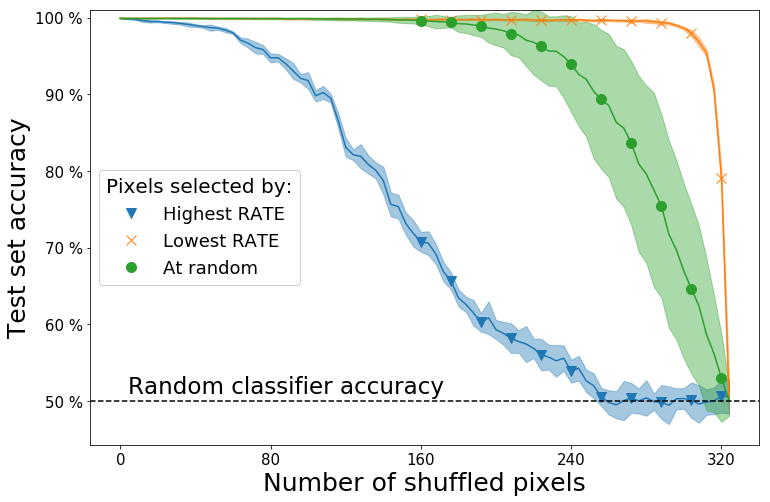

In [31]:
plot_data = res
labels = ["RATE_high", "RATE_low", "random"]
legend_labels = ["Highest RATE", "Lowest RATE", "At random"]
    
legend_labels = {key: value for (key, value) in zip(labels, legend_labels)}

marker_cutoff = 40
marker_size = 10
marker_gap = 4
marker_dict = {key: value for (key, value) in zip(plot_data.keys(), ["v", "o", "x"])}
    
fig, ax = plt.subplots(figsize=(12,8))

for l in labels:
    k = l
    v = np.array(plot_data[l])
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(100.0*v.mean(axis=1),c=color)
    ax.fill_between(np.arange(len(v)), 100.0*v.mean(axis=1)-200.0*v.std(axis=1), 100.0*v.mean(axis=1)+200.0*v.std(axis=1),
                   alpha=0.4, color=color)
    ax.plot(np.arange(marker_cutoff, len(v), 1)[::marker_gap], 100.0*v.mean(axis=1)[marker_cutoff::marker_gap], marker_dict[k],
            c=color,
           markersize=marker_size,
           label=legend_labels[k])

leg = ax.legend(loc="center left", fontsize=18, fancybox=True, framealpha=1.0, ncol=1)
leg.set_title("Pixels selected by:", prop = {'size':20})
xticklocs = ax.get_xticklabels()

ax.set_xticks(np.arange(ax.get_xlim()[1])[::20])
ax.set_xticklabels(np.arange(0, p+1, 4)[::20])
ax.set_yticklabels(["{} %".format(val) for val in np.arange(40, 101, 10)])
ax.tick_params("both", labelsize=15)
ax.set_ylabel("Test set accuracy", fontsize=25)
ax.set_xlabel("Number of shuffled pixels", fontsize=25)
ax.set_ylim([ax.get_ylim()[0], 101])

ax.axhline(50.0, ls="--", color="black")

ax.text(1, 51.0, "Random classifier accuracy", size=23)

fig.savefig("mnist_binary_test_accuracy.pdf", bbox_inches="tight")